<a href="https://colab.research.google.com/github/Chenzhang0329/StockPrice-Hybrid-Model-/blob/main/Final_Assignment_Main_Good_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecasting with a Hybrid Deep Learning Model

# 1.0 Introduction

#2.0 Data Collection and Preprocessing


##2.1 Imports and Configurations

In [1]:
#Import necessary libraries 
import pandas as pd
!pip install yfinance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time
from google.colab import files
import yfinance as yf
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import multiprocessing as mp
import datetime as dt
from multiprocessing import Process



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.8 MB/s eta 0:00:00


In [2]:
#configure sentiment analysis pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model = finbert, tokenizer = tokenizer)
sentiment_dict = {'Negative':-1, 'Neutral':0, 'Positive': 1}
ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
#clone git repo into workspace
!git clone https://github.com/Chenzhang0329/StockPrice-Hybrid-Model-.git

Cloning into 'StockPrice-Hybrid-Model-'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 259 (delta 12), reused 0 (delta 0), pack-reused 230
Receiving objects: 100% (259/259), 8.12 MiB | 9.92 MiB/s, done.
Resolving deltas: 100% (123/123), done.


## 2.2 Setup of Data Collection Functions

In [3]:
# Retrieve financial info from active directory and feature engineer to scale the outcomes to the value of the mean sentiment scores *  count^2
from sklearn.preprocessing import MinMaxScaler
def pull_news(ticker):
    path = '/content/StockPrice-Hybrid-Model-/News Data/'+ticker+'_news.csv'
    news_df = pd.read_csv(path)
    news_list = news_df['headline'].to_list()
    print('success1')
    result = nlp(news_list)
    print('success2')
    result = pd.DataFrame(result)
    news_df["sentiment"] = [sentiment_dict[k]for k in result['label']]  
    news_df['date'] = pd.to_datetime(news_df['date'], format = '%d-%m-%Y')
    sentiment = pd.DataFrame()
    sentiment['mean'] = news_df.groupby(by="date")["sentiment"].mean()
    sentiment['count']= news_df.groupby(by='date')['sentiment'].count()
    sentiment['score'] = sentiment['mean'] * (sentiment['count']**2)
    sentiment = sentiment.fillna(0)
    scaler1 = MinMaxScaler()
    sentiment['score'] = scaler1.fit_transform(sentiment[['score']])
    path3 = ticker+'_sentimentscore.csv'
    sentiment.to_csv(path3)  

#retrieve financial information using yfinance
def get_financials(ticker, start):
    time_delt = dt.timedelta(days = 150)
    start_day = start - time_delt
    data = yf.download(str(ticker), start_day)
    data['ticker'] = ticker
    data = data.reset_index()
    print('success!')
    return data

#Caclulate Exponential moving average
def EWMA(data, ndays): 
    EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(), 
                 name = 'EWMA_' + str(ndays)) 
    data = data.join(EMA) 
    return data

# Calculate Relative Strength Index
def rsi(close, periods = 14):
    
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Calculate Bollinger Bands
def BBANDS(data, window):
    MA = data.close.rolling(window).mean()
    SD = data.close.rolling(window).std()
    data['MiddleBand'] = MA
    data['UpperBand'] = MA + (2 * SD) 
    data['LowerBand'] = MA - (2 * SD)
    return data

# Rolling averages for 10,20,50, and 100 days  feature engineering
def prep_financials(df):
    df = pd.DataFrame(df)
    df.set_index('date')
    df['target'] = (df['close'])
    df['10mda'] = df['close'].rolling(10).mean()
    df['20mda'] = df['close'].rolling(20).mean()
    df['50mda'] = df['close'].rolling(50).mean()
    df['100mda'] = df['close'].rolling(100).mean()
    #df['target'] = [1 if df['pct_change'].loc[i] >0.005 else 0 for i in df.index]
    df = EWMA(df, 20)
    df = EWMA(df, 50) 
    df = EWMA(df, 100)
    df['rsi'] = rsi(df['close'])
    df = BBANDS(df, 20)
    #df.drop(['pct_change'], axis=1, inplace=True)
    df.reset_index()
    return df

In [ ]:
#parallel process to calculate all sentiment scores and process sentiment data into csv files
import datetime as dt
if __name__ == "__main__":
    ticker_list = ['MSFT','GOOG', 'AMZN','TSLA','NFLX']
    processes = []
    proc = Process(target=pull_news)
    processes.append(proc)
    proc.start()

    for tick in ticker_list:
        proc = Process(target =pull_news, args=(tick,))
        processes.append(proc)
        proc.start()
    
    for proc in processes:
        proc.join()


Process Process-1:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
TypeError: pull_news() missing 1 required positional argument: 'ticker'


success1success1

success1
success1
success1
success2
success2
success2
success2
success2


In [4]:
#Complete financial info retrieval
finance_dfs = []
for tick in ticker_list:
    data = get_financials(tick, dt.date(2018,1, 1))
    data.rename(columns = {'Date':'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close','Adj Close': 'adj_close', 'Volume':'volume'}, inplace = True)
    print(data.info())
    prepped = prep_financials(data)
    finance_dfs.append(prepped)

#read finance data to csv
full_finance = pd.concat(finance_dfs)
full_finance.to_csv('finance.csv', index = False)

[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1432 non-null   datetime64[ns]
 1   open       1432 non-null   float64       
 2   high       1432 non-null   float64       
 3   low        1432 non-null   float64       
 4   close      1432 non-null   float64       
 5   adj_close  1432 non-null   float64       
 6   volume     1432 non-null   int64         
 7   ticker     1432 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 89.6+ KB
None
[*********************100%***********************]  1 of 1 completed
success!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     ------------

#  3.0 Exploratory Data Analysis(EDA) and Data Cleaning
All data collection and initial prep is completed at this point.

In [5]:
#retrieve sentiment scores and create dataframes with only score and date columns
sentiment_dfs = []
for i in ticker_list:
  data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Sentiment Score/'+i+'_sentimentscore.csv')
  data['date'] = pd.to_datetime(data['date'])
  df = data[['date','score']]
  sentiment_dfs.append(df)
#Check distribution of sentiment dataframe
print(sentiment_dfs[1].describe())

             score
count  1410.000000
mean      0.347804
std       0.046656
min       0.000000
25%       0.343666
50%       0.345013
75%       0.349057
max       1.000000


## 3.1 Create Final Dataframes to Include Both Sentiment Data and Financial Data 

In [6]:
financials = pd.read_csv('finance.csv')
#function to separate dataframe by company
def separate_companies(ticker, df):
    dataframe = df[df['ticker']==ticker]
    return dataframe

#separate dataframes for each company and add new features
df_list = []
for tick in ticker_list:
    data = separate_companies(tick, financials)
    data.reset_index()
    data['date'] = pd.to_datetime(data['date'])
    df_list.append(data)


goog = df_list[1].set_index('date').join(sentiment_dfs[1].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[1].mean())
msft = df_list[0].set_index('date').join(sentiment_dfs[0].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[0].mean())
amzn = df_list[2].set_index('date').join(sentiment_dfs[2].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[2].mean())
tesla = df_list[3].set_index('date').join(sentiment_dfs[3].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[3].mean())
nflx = df_list[4].set_index('date').join(sentiment_dfs[4].set_index('date'),how = 'left').loc['2018-01-01':'2023-02-01'].fillna(sentiment_dfs[4].mean())

frames = [goog, msft, amzn, tesla, nflx]


<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-6-82c985f0176a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

## 3.2 EDA to Explore Change in Stock Prices and Daily Headlines

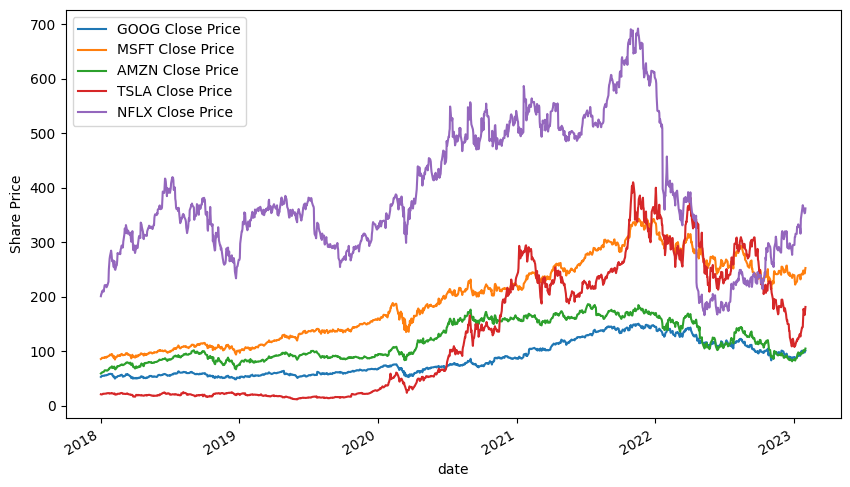

KeyError: ignored

In [7]:
#EDA and summary stats for compiled datasets
ticker_list = ['GOOG', 'MSFT','AMZN','TSLA','NFLX']
plt.figure(figsize = (10, 6))
frames = [goog, msft, amzn, tesla, nflx]
#create plot to display change in share price
for i, frame in enumerate(frames):
  frame['close'].plot(label = ticker_list[i]+' Close Price')
plt.ylabel('Share Price')
plt.legend()
plt.show()

#create plot to display daily number of headlines as a 20 day rolling average 
rollings = []
for i, frame in enumerate(frames):
  frame['average headlines'] = frame['headline'].rolling(20).mean()
  rollings.append(frame)
plt.figure(figsize = (12, 8))
for i, frame in enumerate(rollings):
  frame['average headlines'].plot(label = ticker_list[i]+' # Daily Headlines')
plt.legend()
plt.ylabel('20 Day Rolling Average Number of Headlines ')
plt.show()


## 3.3 Scale Data and Configure Training/Test Datasets 

In [8]:
from sklearn.preprocessing import MinMaxScaler
# drop irrevelant columns
data = frames[1] # data for microsoft
data = data.drop(['ticker'],axis=1)
 
# features and target columns
target_scaler = MinMaxScaler()
target = target_scaler.fit_transform(data[['target']])
score = data['score']
X_feat = data.drop(['target', 'score'], axis = 1)

# Normalise the data
for col in X_feat.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    X_feat[col] = scaler.fit_transform(X_feat[[col]])
X_feat['score'] = score
X_ft = np.array(X_feat)
# Creating a data structure with 10 time-steps and 1 output
 
# Split data into X_train and y_train data sets
def lstm_split(data,target,steps):
  X = []
  y = []
  # Creating a data structure with 10 time-steps and 1 output
  for i in range(10, steps):
      X.append(data[i-10:i])
      y.append(target[i])  
  return np.array(X),np.array(y)
 
X1,y1 = lstm_split(X_feat,target,len(X_ft))
 

 # function to split  data 90% training-10% testing
def train_split(x1, y1, train_data):
  split = 0.9
  split_idx = int(np.ceil(len(X1)*split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test
  
X_train, X_test, y_train, y_test = train_split(X1, y1, frames[1])
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1270, 10, 18) (1143, 10, 18) (127, 10, 18) (127, 1) (1143, 1)


# 4.0 Single Company Model Implementation

This section contains the necessary code to define our model and train/test the standalone LSTM as well as the hybrid ensemble model. 

## 4.1 Build  & Validate the LSTM Model on Microsoft Stock
The general architecture of the model is available below. Specific hyperparameters will be defined during the training process using RandomSearch.

In [9]:
#LSTM Framework for MSFT
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner


#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
EPOCH = 200
BATCH = 24
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mean_squared_error'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective= keras_tuner.Objective('val_loss', direction='min'), max_trials = 50, seed = 2)

#complete training 
tune.search(X_train, y_train, epochs = EPOCH, batch_size = BATCH, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]

#validating the training
test_predictions = LSTM_model.evaluate(X_train, y_train)
print(test_predictions)
LSTM_model.save('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5')
hyperparameters = tune.get_best_hyperparameters(1)[0]
print(hyperparameters.values)

Trial 50 Complete [00h 00m 30s]
val_loss: 0.014612757600843906

Best val_loss So Far: 0.0009332090266980231
Total elapsed time: 00h 29m 26s
36/36 [==============================] - 1s 4ms/step - loss: 9.4326e-04 - mean_squared_error: 9.4326e-04
[0.0009432630613446236, 0.0009432630613446236]
{'n_hidden': 0, 'neurons_visible': 78, 'activate1': 'sigmoid', 'dropout1': 0.7, 'neurons_hidden1': 50, 'dropout2': 0.4, 'neurons_hidden2': 30, 'dropout3': 0.7, 'neurons_hidden3': 30}


##4.2 LSTM Model Testing

### 4.2.2 Evaluate LSTM Model Success on MSFT Test Data

In [25]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  return model.predict(trainset)


4/4 [==============================] - 0s 7ms/step


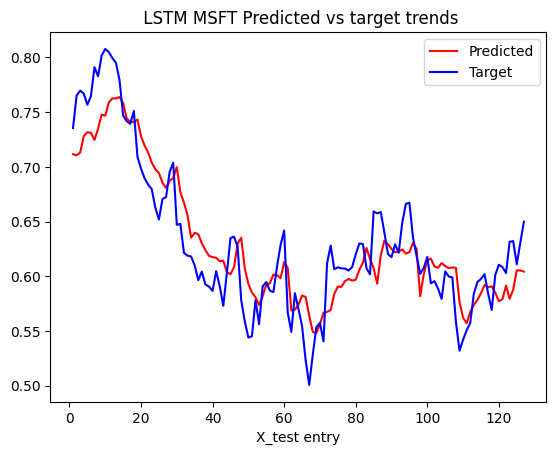

In [11]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_test = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_test)
LSTM_MSFT_test.shape

import matplotlib.pyplot as plt
x=np.arange(1,len(y_test)+1, 1)
plt.plot(x,LSTM_MSFT_test.flatten(), "r", label= "Predicted")
plt.plot(x,y_test, "b", label= "Target")

plt.title(" LSTM MSFT Predicted vs target trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

### 4.2.1 Format Test Data to Reflect Training Data for Google Stock

In [12]:
# prep google test data
google = frames[0]
google_scaler = MinMaxScaler()
google_target = google_scaler.fit_transform(google[['target']])
google_score = google['score']
test_ft = google.drop(['target', 'score', 'ticker'], axis = 1)

# Normalise the data
for col in test_ft.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ft[col] = scaler.fit_transform(test_ft[[col]])
test_ft['score'] = google_score
test_ft = np.array(test_ft)

google_ft, google_target = lstm_split(test_ft,google_target,len(test_ft))

In [13]:
#test LSTM model using X_train for GOOG
LSTM_GOOG_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', google_ft)
LSTM_GOOG_yhat.shape

40/40 [==============================] - 0s 3ms/step


(1270, 1)

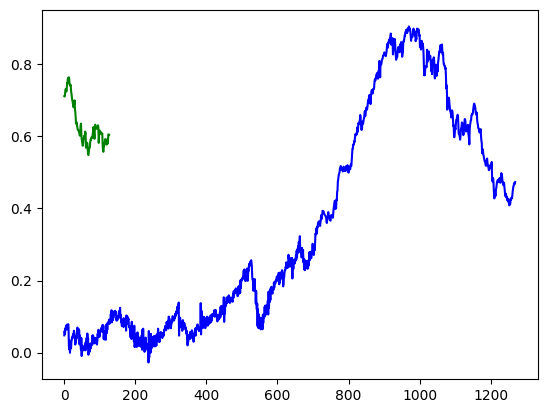

In [14]:
# compare LSTM on trained on MSFT on predictions for Google
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_test, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()




##4.3 Prophet Model



For this section is how we gonna fit the prophet model by using miscosoft company stock price data. The best hyperparameter we get by using the cross-validation

In [15]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

In [16]:
# Uploaded stock price csv
finance_data = pd.read_csv('/content/StockPrice-Hybrid-Model-/Finance Data/finance.csv')
finance_data.head()

,date,open,high,low,close,adj_close,volume,ticker,10mda,20mda,50mda,100mda,target,EWMA_20,EWMA_50,EWMA_100,rsi,MiddleBand,UpperBand,LowerBand
0,2017-08-04,72.400002,73.040001,72.239998,72.680000,67.571640,22579000,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-07,72.800003,72.900002,72.260002,72.400002,67.311348,18705700,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-08,72.089996,73.129997,71.750000,72.790001,67.673927,22044600,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-09,72.250000,72.510002,72.050003,72.470001,67.376427,22213400,MSFT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-10,71.900002,72.190002,71.349998,71.410004,66.390930,24734500,MSFT,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
MSFT_Data = finance_data[finance_data['ticker']=='MSFT']
Google_Data = finance_data[finance_data['ticker']=='GOOG']
# This function is used to get the train data and test data
def data_preparation(df):
  data=df[["date","adj_close"]]
  data = data.rename(columns = {'date':'ds', 'adj_close':'y'})
  return data


In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(data_preparation(MSFT_Data))

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

### 4.3.1 Forecasting with Prophet

In [18]:
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(data_preparation(df))
  df = cross_validation(model=final_model, initial='124 days', horizon='10 days', period='10 days')
  return df

In [19]:
MSFT_train_data = get_data(MSFT_Data)[['ds', 'yhat']]
MSFT_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/80axx0to.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/3ll0o22i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58883', 'data', 'file=/tmp/tmponyuemge/80axx0to.json', 'init=/tmp/tmponyuemge/3ll0o22i.json', 'output', 'file=/tmp/tmponyuemge/prophet_model3r00hdsf/prophet_model-20230413143241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/bk3qi7xr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/jsfl1epe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42673', 'data', 'file=/tmp/tmponyuemge/bk3qi7xr.json', 'init=/tmp/tmponyuemge/jsfl1epe.json', 'output', 'file=/tmp/tmponyuemge/prophet_modelzakkeo8i/prophet_model-20230413143248.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:32:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:32:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/4g7q3t8q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/yukp4cv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,73.970595
1,2017-12-19,68.597337
2,2017-12-20,60.279245
3,2017-12-21,49.091784
4,2017-12-22,34.894607


In [20]:
Google_train_data = get_data(Google_Data)[['ds', 'yhat']]
Google_train_data.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/bspn90_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/4lxgby1s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56349', 'data', 'file=/tmp/tmponyuemge/bspn90_r.json', 'init=/tmp/tmponyuemge/4lxgby1s.json', 'output', 'file=/tmp/tmponyuemge/prophet_modelcpyp7jto/prophet_model-20230413143812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:38:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 191 forecasts with cutoffs between 2017-12-15 00:00:00 and 2023-02-27 00:00:00


  0%|          | 0/191 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/4h6mj3x3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/__0s1uqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54720', 'data', 'file=/tmp/tmponyuemge/4h6mj3x3.json', 'init=/tmp/tmponyuemge/__0s1uqy.json', 'output', 'file=/tmp/tmponyuemge/prophet_modelul06cx4s/prophet_model-20230413143815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:38:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/9ng2t19m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponyuemge/uhrj5ito.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat
0,2017-12-18,53.406188
1,2017-12-19,53.607782
2,2017-12-20,53.609407
3,2017-12-21,53.306160
4,2017-12-22,52.961331


In [21]:
def prep_prophet(prophet_pred, data1):
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  main_data = data1.join(prophet_pred,how = 'left')
  returned = main_data.loc['2018-01-01':'2023-02-01', 'yhat']
  return returned

goog_data = prep_prophet(Google_train_data, frames[0])[10:]
msft_train_data = prep_prophet(MSFT_train_data, frames[1])[10:1153]
msft_test_data = prep_prophet(MSFT_train_data, frames[1])[1153:]


##4.4 Hybrid Model 

 ### 4.4.1 Define Training Data Using Ouputs from Standalone Models MSFT

In [22]:
#creating y_hybrid from y_train of the LSTM model
print(y_train.shape)
y_hybrid= y_train
print(y_train.shape, y_hybrid.shape)
print(goog_data.shape)

(1143, 1)
(1143, 1) (1143, 1)
(1270,)


In [23]:
#verifying that outputs from both the LSTM and Prohet models match in size
LSTM_MSFT_yhat = testmodel('/content/StockPrice-Hybrid-Model-/Models/LSTM_model.h5', X_train)
print ("LSTM:", LSTM_MSFT_yhat.shape,"\n","Prophet:", msft_train_data.shape)

#merging the the outcomes from the LSTM model and the Prophet model

msft_hybrid = { 'LSTM':LSTM_MSFT_yhat.flatten(), 'prophet':np.array(msft_train_data), }
msft_hybrid_df = pd.DataFrame(msft_hybrid)

#scaling the MSFT_PROPHET column
scaler2 = MinMaxScaler()
msft_hybrid_df['prophet'] = scaler2.fit_transform(msft_hybrid_df[['prophet']])

#Defining the data for the hybrid training
X2_ft = np.array(msft_hybrid_df)
print("y_hybrid", y_hybrid.shape)

X_train2,y_train2 = lstm_split(msft_hybrid_df,y_hybrid,len(msft_hybrid_df))


36/36 [==============================] - 0s 5ms/step
LSTM: (1143, 1) 
 Prophet: (1143,)
y_hybrid (1143, 1)


In [24]:
#LSTM Framework for the hybrid model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
import keras_tuner


#Hybrid model architecture and training
LR = 0.01
EPOCH = 300
BATCH = 24
hybrid = Sequential()
hybrid.add(LSTM(units = 98, activation = "sigmoid", input_shape = (X_train2.shape[1], X_train2.shape[2]), return_sequences = False))
hybrid.add(Dropout(0.5))
hybrid.add(Dense(units =1))
hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

hybrid_history = hybrid.fit(X_train2, y_train2, epochs = EPOCH, batch_size = BATCH, callbacks = [Early_stop])

hybrid_history.model.save('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5')

Epoch 1/300


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


48/48 [==============================] - 2s 9ms/step - loss: 0.2585 - mae: 0.3801
Epoch 2/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0840 - mae: 0.2344
Epoch 3/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0514 - mae: 0.1792
Epoch 4/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0340 - mae: 0.1477
Epoch 5/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0210 - mae: 0.1146
Epoch 6/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0138 - mae: 0.0925
Epoch 7/300
48/48 [==============================] - 0s 10ms/step - loss: 0.0111 - mae: 0.0824
Epoch 8/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0103 - mae: 0.0787
Epoch 9/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0092 - mae: 0.0745
Epoch 10/300
48/48 [==============================] - 0s 9ms/step - loss: 0.0078 - mae: 0.0693
Epoch 11/300
48/48 [==============================] - 0s 9ms/step - lo

###4.4.2 LOSS and MAE

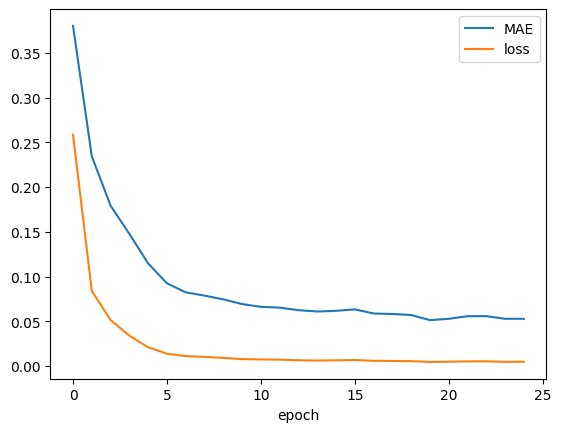

In [26]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### 4.4.3 Comparing output of LSTM MSFT and Hybrid MSFT 

###4.4.4 Hybrid Model Testing on GOOG

In [27]:
#merge lstm test prediction and prophet test prediction
def merge_predictions(lstm_pred,prophet_pred):
  data_dict = {}
  scaler = MinMaxScaler()
  data_dict['LSTM'] = lstm_pred.flatten()
  data_dict['prophet'] = np.array(prophet_pred)
  hybrid_test_data = pd.DataFrame(data_dict)
  hybrid_test_data['prophet'] = scaler.fit_transform(hybrid_test_data[['prophet']])
  return hybrid_test_data

In [28]:
from keras.models import load_model
MSFT_test_hybrid = merge_predictions(LSTM_MSFT_test, msft_test_data)
MSFT_x_test, MSFT_y_test = lstm_split(MSFT_test_hybrid, y_test, len(MSFT_test_hybrid))
MSFT_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', MSFT_x_test)

4/4 [==============================] - 1s 7ms/step


In [29]:
print(LSTM_GOOG_yhat.shape,goog_data.shape)
GOOG_test_hybrid= merge_predictions(LSTM_GOOG_yhat, goog_data)
GOOG_x_test, GOOG_y_test = lstm_split(GOOG_test_hybrid,google_target,len(GOOG_test_hybrid))
GOOG_predictions = testmodel('/content/StockPrice-Hybrid-Model-/Models/Hybrid_model1.h5', GOOG_x_test)


(1270, 1) (1270,)
40/40 [==============================] - 1s 6ms/step


In [45]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    rmse = tf.keras.metrics.RootMeanSquaredError()
    rmse.update_state(true_series, forecast)
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)
    print(f"the root mean square error of the predictions is {rmse.result().numpy()}, and the mean absolute error of the predictions is {mae.result().numpy()}")
    return rmse.result().numpy(), mae.result().numpy()

In [35]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(msft_hybrid_df,y_hybrid)
linear_predictions_GOOG = linear_model.predict(GOOG_test_hybrid)
linear_predictions_MSFT = linear_model.predict(MSFT_test_hybrid)

###4.4.5 Predicted vs Actual Price

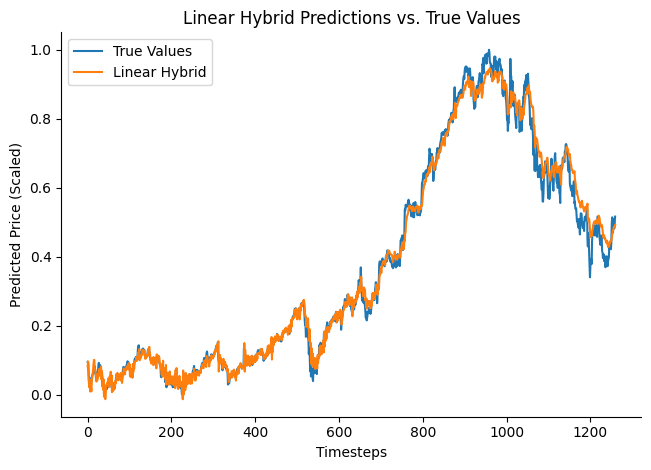

In [61]:

plt.plot(GOOG_y_test, label="True Values")
plt.plot(linear_predictions_GOOG[10:], label="Linear Hybrid")
#plt.plot(GOOG_predictions, label="LSTM Hybrid")
plt.xlabel("Timesteps")
plt.ylabel("Predicted Price (Scaled)")
plt.title('Linear Hybrid Predictions vs. True Values')
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()

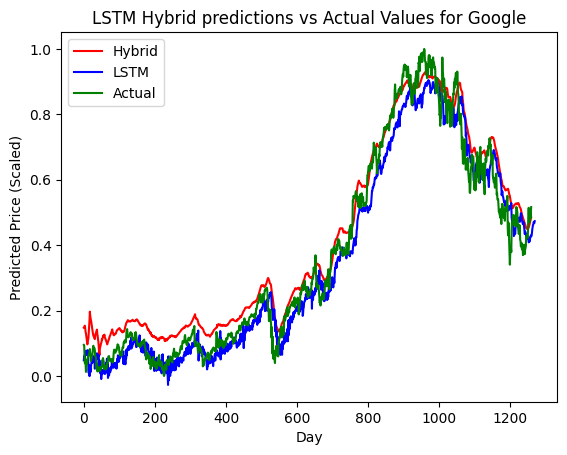

In [60]:
import matplotlib.pyplot as plt
x=np.arange(1,len(GOOG_y_test)+1, 1)
plt.plot(GOOG_predictions.flatten(), "r", label= "Hybrid")
plt.plot(LSTM_GOOG_yhat, "b", label= "LSTM")
plt.plot(GOOG_y_test, "g", label= "Actual")

plt.title("LSTM Hybrid predictions vs Actual Values for Google")
plt.xlabel('Day')
plt.ylabel("Predicted Price (Scaled)")
plt.legend()
plt.show()

## Return Predictions to Original Scale for Final Analysis

In [ ]:
GOOG_scaler = 
MSFT_scaler = 

#5.0 Multiple Company Model

## 5.1 Generate Sub-models

In [38]:
def create_lists(list_of_df):
  training_list = []
  target_list = []
  for i in range(len(list_of_df)):
    scaler = MinMaxScaler()
    data = list_of_df[i]
    score = data['score']
    target = scaler.fit_transform(data[['target']])
    training = data.drop(['target', 'ticker', 'score'], axis = 1)
    for col in training.columns:
      training[col] = scaler.fit_transform(training[[col]])
    training['score'] = score
    data_x, data_y = lstm_split(training, target, len(training))
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 98, activation = "relu", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1, activation = 'sigmoid'))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 24, callbacks = [Early_stop])
    return hybrid

training_list, target_list = create_lists(frames[1:])
for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.save('/content/StockPrice-Hybrid-Model-/sub_models/'+tick+'_lstm.h5')


Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


53/53 [==============================] - ETA: 0s - loss: 0.0163 - mean_squared_error: 0.0163

53/53 [==============================] - 2s 9ms/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 2/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

53/53 [==============================] - 0s 8ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 3/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 4/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 5/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 6/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 7/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 8/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 9/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 10/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 11/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 12/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 13/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 13ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 14/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 16/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 17/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 18/200
52/53 [============================>.] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 19/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 20/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 21/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 22/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 23/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 24/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 25/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 26/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 27/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 28/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 29/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 30/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 31/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 32/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 33/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 34/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 35/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 36/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 37/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 38/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 39/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 40/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 14ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 41/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 12ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 42/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 43/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 44/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 45/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 46/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 47/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 48/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 49/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 50/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 52/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 53/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 54/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 55/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 56/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 57/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 58/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 59/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 60/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 61/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 62/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 63/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 64/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 65/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 66/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 67/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 68/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 69/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 70/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 71/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 72/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 73/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 74/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 75/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 76/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 77/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 78/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 79/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 80/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 81/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 82/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 83/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 84/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 85/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 86/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 87/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 88/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 89/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 90/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 91/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 93/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 94/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 95/200
52/53 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 97/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 98/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 12ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 99/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 100/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 101/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 102/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 103/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 104/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 105/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 106/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 107/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 108/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 109/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 110/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 111/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 112/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 113/200
52/53 [============================>.] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 114/200
52/53 [============================>.] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

53/53 [==============================] - 0s 9ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 115/200
52/53 [============================>.] - ETA: 0s - loss: 0.0295 - mean_squared_error: 0.0295

53/53 [==============================] - 0s 9ms/step - loss: 0.0299 - mean_squared_error: 0.0299
Epoch 116/200
53/53 [==============================] - ETA: 0s - loss: 0.0547 - mean_squared_error: 0.0547

53/53 [==============================] - 0s 9ms/step - loss: 0.0547 - mean_squared_error: 0.0547
Epoch 117/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0321 - mean_squared_error: 0.0321

53/53 [==============================] - 0s 9ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 118/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0434 - mean_squared_error: 0.0434

53/53 [==============================] - 0s 9ms/step - loss: 0.0434 - mean_squared_error: 0.0434
Epoch 119/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0248 - mean_squared_error: 0.0248

53/53 [==============================] - 0s 9ms/step - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.0235 - mean_squared_error: 0.0235

53/53 [==============================] - 0s 9ms/step - loss: 0.0232 - mean_squared_error: 0.0232
Epoch 121/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0167 - mean_squared_error: 0.0167

53/53 [==============================] - 0s 9ms/step - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 122/200
52/53 [============================>.] - ETA: 0s - loss: 0.0361 - mean_squared_error: 0.0361

53/53 [==============================] - 0s 9ms/step - loss: 0.0374 - mean_squared_error: 0.0374
Epoch 123/200
52/53 [============================>.] - ETA: 0s - loss: 0.0609 - mean_squared_error: 0.0609

53/53 [==============================] - 1s 10ms/step - loss: 0.0603 - mean_squared_error: 0.0603
Epoch 124/200
52/53 [============================>.] - ETA: 0s - loss: 0.0663 - mean_squared_error: 0.0663

53/53 [==============================] - 1s 13ms/step - loss: 0.0665 - mean_squared_error: 0.0665
Epoch 125/200
53/53 [==============================] - ETA: 0s - loss: 0.0492 - mean_squared_error: 0.0492

53/53 [==============================] - 1s 13ms/step - loss: 0.0492 - mean_squared_error: 0.0492
Epoch 126/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0309 - mean_squared_error: 0.0309

53/53 [==============================] - 1s 13ms/step - loss: 0.0310 - mean_squared_error: 0.0310
Epoch 127/200
53/53 [==============================] - ETA: 0s - loss: 0.0356 - mean_squared_error: 0.0356

53/53 [==============================] - 1s 12ms/step - loss: 0.0356 - mean_squared_error: 0.0356
Epoch 128/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0531 - mean_squared_error: 0.0531

53/53 [==============================] - 1s 13ms/step - loss: 0.0526 - mean_squared_error: 0.0526
Epoch 129/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0360 - mean_squared_error: 0.0360

53/53 [==============================] - 1s 13ms/step - loss: 0.0362 - mean_squared_error: 0.0362
Epoch 130/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0329 - mean_squared_error: 0.0329

53/53 [==============================] - 1s 11ms/step - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 131/200
52/53 [============================>.] - ETA: 0s - loss: 0.0331 - mean_squared_error: 0.0331

53/53 [==============================] - 0s 9ms/step - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 132/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0341 - mean_squared_error: 0.0341

53/53 [==============================] - 0s 8ms/step - loss: 0.0337 - mean_squared_error: 0.0337
Epoch 133/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0339 - mean_squared_error: 0.0339

53/53 [==============================] - 0s 9ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 134/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0330

53/53 [==============================] - 0s 9ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 135/200
51/53 [===========================>..] - ETA: 0s - loss: 0.1519 - mean_squared_error: 0.1519

53/53 [==============================] - 0s 9ms/step - loss: 0.1549 - mean_squared_error: 0.1549
Epoch 136/200
48/53 [==========================>...] - ETA: 0s - loss: 0.2315 - mean_squared_error: 0.2315

53/53 [==============================] - 0s 9ms/step - loss: 0.2303 - mean_squared_error: 0.2303
Epoch 137/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2288 - mean_squared_error: 0.2288

53/53 [==============================] - 0s 9ms/step - loss: 0.2300 - mean_squared_error: 0.2300
Epoch 138/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2644 - mean_squared_error: 0.2644

53/53 [==============================] - 0s 9ms/step - loss: 0.2675 - mean_squared_error: 0.2675
Epoch 139/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2891 - mean_squared_error: 0.2891

53/53 [==============================] - 0s 9ms/step - loss: 0.2830 - mean_squared_error: 0.2830
Epoch 140/200
48/53 [==========================>...] - ETA: 0s - loss: 0.2742 - mean_squared_error: 0.2742

53/53 [==============================] - 0s 8ms/step - loss: 0.2710 - mean_squared_error: 0.2710
Epoch 141/200
53/53 [==============================] - ETA: 0s - loss: 0.2588 - mean_squared_error: 0.2588

53/53 [==============================] - 0s 9ms/step - loss: 0.2588 - mean_squared_error: 0.2588
Epoch 142/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2634 - mean_squared_error: 0.2634

53/53 [==============================] - 1s 10ms/step - loss: 0.2638 - mean_squared_error: 0.2638
Epoch 143/200
53/53 [==============================] - ETA: 0s - loss: 0.2661 - mean_squared_error: 0.2661

53/53 [==============================] - 0s 9ms/step - loss: 0.2661 - mean_squared_error: 0.2661
Epoch 144/200
48/53 [==========================>...] - ETA: 0s - loss: 0.2606 - mean_squared_error: 0.2606

53/53 [==============================] - 0s 8ms/step - loss: 0.2623 - mean_squared_error: 0.2623
Epoch 145/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2698 - mean_squared_error: 0.2698

53/53 [==============================] - 0s 9ms/step - loss: 0.2700 - mean_squared_error: 0.2700
Epoch 146/200
52/53 [============================>.] - ETA: 0s - loss: 0.2501 - mean_squared_error: 0.2501

53/53 [==============================] - 1s 10ms/step - loss: 0.2498 - mean_squared_error: 0.2498
Epoch 147/200
53/53 [==============================] - ETA: 0s - loss: 0.2541 - mean_squared_error: 0.2541

53/53 [==============================] - 0s 9ms/step - loss: 0.2541 - mean_squared_error: 0.2541
Epoch 148/200
53/53 [==============================] - ETA: 0s - loss: 0.2314 - mean_squared_error: 0.2314

53/53 [==============================] - 0s 8ms/step - loss: 0.2314 - mean_squared_error: 0.2314
Epoch 149/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2375 - mean_squared_error: 0.2375

53/53 [==============================] - 0s 9ms/step - loss: 0.2386 - mean_squared_error: 0.2386
Epoch 150/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2356 - mean_squared_error: 0.2356

53/53 [==============================] - 0s 9ms/step - loss: 0.2387 - mean_squared_error: 0.2387
Epoch 151/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2391 - mean_squared_error: 0.2391

53/53 [==============================] - 1s 9ms/step - loss: 0.2393 - mean_squared_error: 0.2393
Epoch 152/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2441 - mean_squared_error: 0.2441

53/53 [==============================] - 1s 12ms/step - loss: 0.2448 - mean_squared_error: 0.2448
Epoch 153/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2265 - mean_squared_error: 0.2265

53/53 [==============================] - 1s 13ms/step - loss: 0.2264 - mean_squared_error: 0.2264
Epoch 154/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2297 - mean_squared_error: 0.2297

53/53 [==============================] - 1s 13ms/step - loss: 0.2290 - mean_squared_error: 0.2290
Epoch 155/200
53/53 [==============================] - ETA: 0s - loss: 0.2441 - mean_squared_error: 0.2441

53/53 [==============================] - 1s 12ms/step - loss: 0.2441 - mean_squared_error: 0.2441
Epoch 156/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2469 - mean_squared_error: 0.2469

53/53 [==============================] - 1s 13ms/step - loss: 0.2478 - mean_squared_error: 0.2478
Epoch 157/200
53/53 [==============================] - ETA: 0s - loss: 0.2409 - mean_squared_error: 0.2409

53/53 [==============================] - 1s 13ms/step - loss: 0.2409 - mean_squared_error: 0.2409
Epoch 158/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2463 - mean_squared_error: 0.2463

53/53 [==============================] - 1s 12ms/step - loss: 0.2476 - mean_squared_error: 0.2476
Epoch 159/200
53/53 [==============================] - ETA: 0s - loss: 0.2572 - mean_squared_error: 0.2572

53/53 [==============================] - 0s 9ms/step - loss: 0.2572 - mean_squared_error: 0.2572
Epoch 160/200
49/53 [==========================>...] - ETA: 0s - loss: 0.2500 - mean_squared_error: 0.2500

53/53 [==============================] - 0s 9ms/step - loss: 0.2475 - mean_squared_error: 0.2475
Epoch 161/200
53/53 [==============================] - ETA: 0s - loss: 0.2474 - mean_squared_error: 0.2474

53/53 [==============================] - 0s 9ms/step - loss: 0.2474 - mean_squared_error: 0.2474
Epoch 162/200
53/53 [==============================] - ETA: 0s - loss: 0.2676 - mean_squared_error: 0.2676

53/53 [==============================] - 0s 9ms/step - loss: 0.2676 - mean_squared_error: 0.2676
Epoch 163/200
53/53 [==============================] - ETA: 0s - loss: 0.3035 - mean_squared_error: 0.3035

53/53 [==============================] - 0s 9ms/step - loss: 0.3035 - mean_squared_error: 0.3035
Epoch 164/200
49/53 [==========================>...] - ETA: 0s - loss: 0.2802 - mean_squared_error: 0.2802

53/53 [==============================] - 0s 9ms/step - loss: 0.2808 - mean_squared_error: 0.2808
Epoch 165/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2830 - mean_squared_error: 0.2830

53/53 [==============================] - 0s 9ms/step - loss: 0.2834 - mean_squared_error: 0.2834
Epoch 166/200
52/53 [============================>.] - ETA: 0s - loss: 0.2952 - mean_squared_error: 0.2952

53/53 [==============================] - 0s 9ms/step - loss: 0.2958 - mean_squared_error: 0.2958
Epoch 167/200
53/53 [==============================] - ETA: 0s - loss: 0.3303 - mean_squared_error: 0.3303

53/53 [==============================] - 0s 8ms/step - loss: 0.3303 - mean_squared_error: 0.3303
Epoch 168/200
53/53 [==============================] - ETA: 0s - loss: 0.3214 - mean_squared_error: 0.3214

53/53 [==============================] - 0s 9ms/step - loss: 0.3214 - mean_squared_error: 0.3214
Epoch 169/200
52/53 [============================>.] - ETA: 0s - loss: 0.3169 - mean_squared_error: 0.3169

53/53 [==============================] - 0s 9ms/step - loss: 0.3172 - mean_squared_error: 0.3172
Epoch 170/200
50/53 [===========================>..] - ETA: 0s - loss: 0.3099 - mean_squared_error: 0.3099

53/53 [==============================] - 0s 9ms/step - loss: 0.3063 - mean_squared_error: 0.3063
Epoch 171/200
47/53 [=========================>....] - ETA: 0s - loss: 0.3078 - mean_squared_error: 0.3078

53/53 [==============================] - 0s 8ms/step - loss: 0.3140 - mean_squared_error: 0.3140
Epoch 172/200
47/53 [=========================>....] - ETA: 0s - loss: 0.2974 - mean_squared_error: 0.2974

53/53 [==============================] - 0s 8ms/step - loss: 0.2923 - mean_squared_error: 0.2923
Epoch 173/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2627 - mean_squared_error: 0.2627

53/53 [==============================] - 0s 9ms/step - loss: 0.2631 - mean_squared_error: 0.2631
Epoch 174/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2544 - mean_squared_error: 0.2544

53/53 [==============================] - 0s 9ms/step - loss: 0.2550 - mean_squared_error: 0.2550
Epoch 175/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2635 - mean_squared_error: 0.2635

53/53 [==============================] - 1s 13ms/step - loss: 0.2626 - mean_squared_error: 0.2626
Epoch 176/200
53/53 [==============================] - ETA: 0s - loss: 0.2532 - mean_squared_error: 0.2532

53/53 [==============================] - 1s 13ms/step - loss: 0.2532 - mean_squared_error: 0.2532
Epoch 177/200
53/53 [==============================] - ETA: 0s - loss: 0.2663 - mean_squared_error: 0.2663

53/53 [==============================] - 1s 11ms/step - loss: 0.2663 - mean_squared_error: 0.2663
Epoch 178/200
48/53 [==========================>...] - ETA: 0s - loss: 0.2678 - mean_squared_error: 0.2678

53/53 [==============================] - 0s 9ms/step - loss: 0.2694 - mean_squared_error: 0.2694
Epoch 179/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2716 - mean_squared_error: 0.2716

53/53 [==============================] - 1s 20ms/step - loss: 0.2718 - mean_squared_error: 0.2718
Epoch 180/200
53/53 [==============================] - ETA: 0s - loss: 0.2703 - mean_squared_error: 0.2703

53/53 [==============================] - 1s 13ms/step - loss: 0.2703 - mean_squared_error: 0.2703
Epoch 181/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2821 - mean_squared_error: 0.2821

53/53 [==============================] - 1s 14ms/step - loss: 0.2842 - mean_squared_error: 0.2842
Epoch 182/200
53/53 [==============================] - ETA: 0s - loss: 0.2640 - mean_squared_error: 0.2640

53/53 [==============================] - 1s 15ms/step - loss: 0.2640 - mean_squared_error: 0.2640
Epoch 183/200
52/53 [============================>.] - ETA: 0s - loss: 0.2575 - mean_squared_error: 0.2575

53/53 [==============================] - 1s 18ms/step - loss: 0.2591 - mean_squared_error: 0.2591
Epoch 184/200
53/53 [==============================] - ETA: 0s - loss: 0.2587 - mean_squared_error: 0.2587

53/53 [==============================] - 1s 22ms/step - loss: 0.2587 - mean_squared_error: 0.2587
Epoch 185/200
53/53 [==============================] - ETA: 0s - loss: 0.2555 - mean_squared_error: 0.2555

53/53 [==============================] - 1s 17ms/step - loss: 0.2555 - mean_squared_error: 0.2555
Epoch 186/200
53/53 [==============================] - ETA: 0s - loss: 0.2685 - mean_squared_error: 0.2685

53/53 [==============================] - 1s 13ms/step - loss: 0.2685 - mean_squared_error: 0.2685
Epoch 187/200
52/53 [============================>.] - ETA: 0s - loss: 0.2641 - mean_squared_error: 0.2641

53/53 [==============================] - 1s 15ms/step - loss: 0.2636 - mean_squared_error: 0.2636
Epoch 188/200
52/53 [============================>.] - ETA: 0s - loss: 0.2689 - mean_squared_error: 0.2689

53/53 [==============================] - 1s 13ms/step - loss: 0.2691 - mean_squared_error: 0.2691
Epoch 189/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2619 - mean_squared_error: 0.2619

53/53 [==============================] - 1s 14ms/step - loss: 0.2622 - mean_squared_error: 0.2622
Epoch 190/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2542 - mean_squared_error: 0.2542

53/53 [==============================] - 1s 19ms/step - loss: 0.2533 - mean_squared_error: 0.2533
Epoch 191/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2659 - mean_squared_error: 0.2659

53/53 [==============================] - 1s 19ms/step - loss: 0.2658 - mean_squared_error: 0.2658
Epoch 192/200
53/53 [==============================] - ETA: 0s - loss: 0.2559 - mean_squared_error: 0.2559

53/53 [==============================] - 1s 19ms/step - loss: 0.2559 - mean_squared_error: 0.2559
Epoch 193/200
53/53 [==============================] - ETA: 0s - loss: 0.2779 - mean_squared_error: 0.2779

53/53 [==============================] - 1s 18ms/step - loss: 0.2779 - mean_squared_error: 0.2779
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.2559 - mean_squared_error: 0.2559

53/53 [==============================] - 1s 16ms/step - loss: 0.2573 - mean_squared_error: 0.2573
Epoch 195/200
50/53 [===========================>..] - ETA: 0s - loss: 0.2639 - mean_squared_error: 0.2639

53/53 [==============================] - 1s 15ms/step - loss: 0.2627 - mean_squared_error: 0.2627
Epoch 196/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2529 - mean_squared_error: 0.2529

53/53 [==============================] - 1s 16ms/step - loss: 0.2553 - mean_squared_error: 0.2553
Epoch 197/200
52/53 [============================>.] - ETA: 0s - loss: 0.2639 - mean_squared_error: 0.2639

53/53 [==============================] - 1s 19ms/step - loss: 0.2649 - mean_squared_error: 0.2649
Epoch 198/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2608 - mean_squared_error: 0.2608

53/53 [==============================] - 1s 24ms/step - loss: 0.2603 - mean_squared_error: 0.2603
Epoch 199/200
53/53 [==============================] - ETA: 0s - loss: 0.2725 - mean_squared_error: 0.2725

53/53 [==============================] - 1s 23ms/step - loss: 0.2725 - mean_squared_error: 0.2725
Epoch 200/200
51/53 [===========================>..] - ETA: 0s - loss: 0.2681 - mean_squared_error: 0.2681

53/53 [==============================] - 1s 25ms/step - loss: 0.2710 - mean_squared_error: 0.2710
Epoch 1/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0243 - mean_squared_error: 0.0243

53/53 [==============================] - 5s 9ms/step - loss: 0.0237 - mean_squared_error: 0.0237
Epoch 2/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0114 - mean_squared_error: 0.0114

53/53 [==============================] - 0s 9ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 3/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0103 - mean_squared_error: 0.0103

53/53 [==============================] - 0s 9ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 4/200
53/53 [==============================] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

53/53 [==============================] - 0s 8ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

53/53 [==============================] - 0s 8ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 6/200
53/53 [==============================] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

53/53 [==============================] - 0s 9ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 7/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 0s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 8/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 0s 9ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 9/200
53/53 [==============================] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 10/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 11/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 12/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 13/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 11ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 14/200
53/53 [==============================] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 1s 13ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 16/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

53/53 [==============================] - 1s 12ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 17/200
52/53 [============================>.] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 1s 13ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 18/200
53/53 [==============================] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 14ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 19/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 13ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 20/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 14ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 21/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

53/53 [==============================] - 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 22/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 23/200
52/53 [============================>.] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 24/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 25/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 26/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 27/200
53/53 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 0s 8ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 28/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 29/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 30/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

53/53 [==============================] - 0s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 31/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 32/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 33/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 34/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 0s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 35/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 36/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 37/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 38/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 39/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 40/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 41/200
53/53 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 42/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 13ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 43/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 12ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 44/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 45/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 46/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 13ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 47/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 13ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 48/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 15ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 49/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 50/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 51/200
52/53 [============================>.] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 52/200
52/53 [============================>.] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 53/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 54/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 55/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 56/200
52/53 [============================>.] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 1s 10ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 57/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 58/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

53/53 [==============================] - 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 59/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 60/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 61/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 62/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 63/200
52/53 [============================>.] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

53/53 [==============================] - 0s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 64/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 10ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 65/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 66/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 67/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 68/200
52/53 [============================>.] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 10ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 69/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 12ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 70/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 13ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 71/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 13ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 72/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 13ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 73/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 14ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 74/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 14ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 75/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 15ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 76/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 77/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 78/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 79/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 80/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 81/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 82/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 83/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 84/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 10ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 85/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 86/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 87/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 88/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 89/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 90/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 91/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 93/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 94/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 95/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 96/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 97/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 98/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 14ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 99/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 13ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 100/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 13ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 101/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 14ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 102/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 103/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 12ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 104/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 105/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 106/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 107/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 108/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 109/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 110/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 111/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 0s 9ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 112/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 113/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 114/200
53/53 [==============================] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 115/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 116/200
52/53 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 117/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 118/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 119/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 120/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 121/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 122/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 123/200
53/53 [==============================] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 124/200
52/53 [============================>.] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 12ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 125/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 126/200
53/53 [==============================] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 127/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 128/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 13ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 130/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 131/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 13ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 132/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 133/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 134/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 135/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 136/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 137/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

53/53 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 138/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 139/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 140/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 141/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 142/200
53/53 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 143/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 144/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 145/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 146/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 147/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 148/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 149/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 150/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 151/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 152/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 153/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 154/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 155/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 156/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 157/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 13ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 158/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 13ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 159/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 13ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 160/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 13ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 161/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 162/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 163/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 164/200
53/53 [==============================] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 165/200
52/53 [============================>.] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 166/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 167/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 0s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 168/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 9ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 169/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 170/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 171/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 172/200
52/53 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 173/200
53/53 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 174/200
52/53 [============================>.] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 11ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 175/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 176/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 177/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 178/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 179/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 14ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 180/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 15ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 181/200
53/53 [==============================] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 182/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 183/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 14ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 184/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 14ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 185/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 14ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 186/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 15ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 187/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 11ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 188/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 189/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 190/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 191/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 192/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 193/200
52/53 [============================>.] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 194/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 195/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 196/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 197/200
52/53 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 198/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 199/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 200/200
52/53 [============================>.] - ETA: 0s - loss: 0.0065 - mean_squared_error: 0.0065

53/53 [==============================] - 1s 10ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 1/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0199 - mean_squared_error: 0.0199

53/53 [==============================] - 2s 10ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

53/53 [==============================] - 0s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 3/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 4/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 13ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 5/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 6/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 7/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 8/200
53/53 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 9/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 10/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 11/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 12/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 13/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 14/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 15/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 16/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 17/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 18/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 19/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 20/200
53/53 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 21/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 22/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 23/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 24/200
47/53 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 25/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 26/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 27/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 28/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 29/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 30/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 31/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 32/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 33/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 14ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 34/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 35/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 36/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 37/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 38/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 39/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 40/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 41/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 42/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 43/200
52/53 [============================>.] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 44/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 45/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 46/200
53/53 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 47/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 48/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 49/200
52/53 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 50/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 51/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 52/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 53/200
52/53 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 55/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 56/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 57/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 58/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 59/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 60/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 61/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 62/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 63/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 64/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 65/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 66/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 14ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 67/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 68/200
53/53 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 69/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 71/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 72/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 73/200
53/53 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 74/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 75/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 76/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 77/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 78/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 79/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 80/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 81/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 82/200
53/53 [==============================] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 83/200
53/53 [==============================] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 84/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 85/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 86/200
53/53 [==============================] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 87/200
53/53 [==============================] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 88/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 89/200
52/53 [============================>.] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

53/53 [==============================] - 1s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 91/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 92/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 93/200
52/53 [============================>.] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 94/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 95/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 96/200
52/53 [============================>.] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

53/53 [==============================] - 1s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 97/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 98/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

53/53 [==============================] - 1s 11ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 99/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 100/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 101/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

53/53 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 102/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 103/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 104/200
53/53 [==============================] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

53/53 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 105/200
52/53 [============================>.] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 106/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 107/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 108/200
53/53 [==============================] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

53/53 [==============================] - 1s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 109/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

53/53 [==============================] - 1s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 110/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

53/53 [==============================] - 1s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 111/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

53/53 [==============================] - 1s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 112/200
52/53 [============================>.] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

53/53 [==============================] - 1s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 113/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 114/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 115/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 116/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0161 - mean_squared_error: 0.0161

53/53 [==============================] - 1s 12ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 117/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0190 - mean_squared_error: 0.0190

53/53 [==============================] - 1s 14ms/step - loss: 0.0193 - mean_squared_error: 0.0193
Epoch 118/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0506 - mean_squared_error: 0.0506

53/53 [==============================] - 1s 13ms/step - loss: 0.0553 - mean_squared_error: 0.0553
Epoch 119/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0109 - mean_squared_error: 0.0109

53/53 [==============================] - 1s 12ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 120/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 1s 13ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 121/200
53/53 [==============================] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 122/200
52/53 [============================>.] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 123/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 124/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 125/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 126/200
52/53 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 11ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 127/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 128/200
52/53 [============================>.] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 129/200
53/53 [==============================] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 10ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 130/200
53/53 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 131/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 132/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 133/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 134/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 135/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 136/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 137/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 138/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 139/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 140/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 141/200
52/53 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 142/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 143/200
52/53 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

53/53 [==============================] - 1s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 144/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 145/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 146/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 147/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 148/200
52/53 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 149/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

53/53 [==============================] - 1s 15ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 150/200
52/53 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 151/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 152/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 153/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

53/53 [==============================] - 1s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 154/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 155/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 156/200
52/53 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 157/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 158/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 159/200
52/53 [============================>.] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 160/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 161/200
53/53 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

53/53 [==============================] - 1s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 162/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 163/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 164/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 165/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 166/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 167/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 168/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 169/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 170/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 171/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 172/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 173/200
53/53 [==============================] - ETA: 0s - loss: 0.0068 - mean_squared_error: 0.0068

53/53 [==============================] - 1s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 174/200
53/53 [==============================] - ETA: 0s - loss: 0.0244 - mean_squared_error: 0.0244

53/53 [==============================] - 1s 15ms/step - loss: 0.0244 - mean_squared_error: 0.0244
Epoch 175/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0149 - mean_squared_error: 0.0149

53/53 [==============================] - 1s 15ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 176/200
52/53 [============================>.] - ETA: 0s - loss: 0.0110 - mean_squared_error: 0.0110

53/53 [==============================] - 1s 16ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 177/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

53/53 [==============================] - 1s 14ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 178/200
52/53 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 11ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 179/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 180/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 181/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 182/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

53/53 [==============================] - 1s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 183/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 184/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 185/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 186/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 187/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 188/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 189/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 190/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 191/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 192/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 10ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 193/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 194/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 195/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 196/200
53/53 [==============================] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

53/53 [==============================] - 1s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 197/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 13ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 198/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 14ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 199/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 14ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 200/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 1/200
53/53 [==============================] - ETA: 0s - loss: 0.0166 - mean_squared_error: 0.0166

53/53 [==============================] - 2s 9ms/step - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 2/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

53/53 [==============================] - 1s 15ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 3/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

53/53 [==============================] - 1s 15ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 4/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

53/53 [==============================] - 1s 13ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 5/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

53/53 [==============================] - 1s 13ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 6/200
53/53 [==============================] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

53/53 [==============================] - 1s 13ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 7/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 8/200
53/53 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 9/200
53/53 [==============================] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

53/53 [==============================] - 1s 15ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 10/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 11/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 12/200
52/53 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 11ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 13/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 14/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

53/53 [==============================] - 1s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 15/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 16/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 17/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 18/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 19/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0058

53/53 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 20/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 21/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 22/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 23/200
52/53 [============================>.] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 24/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 10ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 25/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 10ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 26/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 27/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 10ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 28/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 10ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 29/200
52/53 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 30/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

53/53 [==============================] - 1s 14ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 31/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 32/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 33/200
52/53 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 34/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 35/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 36/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 37/200
53/53 [==============================] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 38/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 15ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 39/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 40/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 41/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 42/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 43/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 44/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 45/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 46/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 47/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

53/53 [==============================] - 1s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 48/200
53/53 [==============================] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 49/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 50/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 51/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 52/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 53/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 54/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 55/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 56/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 57/200
53/53 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 58/200
53/53 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 13ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 59/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 60/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 61/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 62/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 63/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 15ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 64/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 65/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 66/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 67/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 68/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 69/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 70/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 71/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 72/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 73/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 10ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 74/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 75/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 76/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 77/200
53/53 [==============================] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 78/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 79/200
52/53 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 80/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 81/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 82/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 83/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 14ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 84/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 85/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 86/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 87/200
52/53 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

53/53 [==============================] - 1s 15ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 88/200
52/53 [============================>.] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 89/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 90/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 91/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 92/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 93/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 94/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 95/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 96/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 97/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 98/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 99/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 100/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 101/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 102/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 103/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 104/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 105/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 106/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 107/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 108/200
52/53 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

53/53 [==============================] - 1s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 109/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 14ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 110/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 111/200
52/53 [============================>.] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 112/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 113/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 114/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 115/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 116/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 117/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.0054

53/53 [==============================] - 1s 14ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 118/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 119/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 120/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

53/53 [==============================] - 1s 11ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 121/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 122/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 123/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 124/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 125/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 126/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 127/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 128/200
53/53 [==============================] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 129/200
52/53 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 130/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 131/200
53/53 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 132/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 133/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 134/200
53/53 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 135/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 136/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 137/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 13ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 138/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 139/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 140/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 141/200
53/53 [==============================] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

53/53 [==============================] - 1s 15ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 142/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 143/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 14ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 144/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 145/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 146/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 147/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 148/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 149/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 150/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 151/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 152/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 153/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 154/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 155/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 156/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 157/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 158/200
48/53 [==========================>...] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 159/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 160/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 161/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 16ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 162/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

53/53 [==============================] - 1s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 163/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 164/200
53/53 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 165/200
53/53 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 166/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 167/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 15ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 168/200
52/53 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 169/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 170/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 171/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 172/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 173/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

53/53 [==============================] - 1s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 174/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 175/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 176/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 11ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 177/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 178/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 179/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 180/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 181/200
53/53 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 182/200
53/53 [==============================] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 183/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 184/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 185/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

53/53 [==============================] - 1s 12ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 186/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 15ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 187/200
53/53 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

53/53 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 188/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 189/200
52/53 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

53/53 [==============================] - 1s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 190/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 191/200
51/53 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

53/53 [==============================] - 1s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 192/200
52/53 [============================>.] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

53/53 [==============================] - 1s 15ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 193/200
53/53 [==============================] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 194/200
52/53 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

53/53 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 195/200
49/53 [==========================>...] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

53/53 [==============================] - 1s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 196/200
53/53 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

53/53 [==============================] - 1s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 197/200
52/53 [============================>.] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

53/53 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 198/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

53/53 [==============================] - 1s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 199/200
50/53 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

53/53 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 200/200
53/53 [==============================] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048


### 5.1.1 Configure Hybrid Training Set and Train Hybrid Model

In [39]:
import os

def hybrid_train(direct, ticker_list, hybrid_train, prophet, targets):
    preds_dict = {}
    path = direct
    scaler = MinMaxScaler()
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    preds_df['prophet'] = np.array(prophet)
    preds_df['prophet'] = scaler.fit_transform(preds_df[['prophet']])
    x1,y1 = lstm_split(preds_df, targets, len(preds_df))
    return x1, y1, preds_df, targets

ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_training_data, targets, preds_df, training_y =  hybrid_train('/content/StockPrice-Hybrid-Model-/sub_models/', ticker_list, X_train, msft_train_data, y_hybrid) 
hybrid_expanded = multiple_models(hybrid_training_data, targets)

36/36 [==============================] - 0s 4ms/step
Epoch 1/200


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


43/48 [=========================>....] - ETA: 0s - loss: 0.0237 - mean_squared_error: 0.0237

48/48 [==============================] - 2s 8ms/step - loss: 0.0220 - mean_squared_error: 0.0220
Epoch 2/200
47/48 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

48/48 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 3/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

48/48 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 4/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

48/48 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 5/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

48/48 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 6/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

48/48 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 7/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

48/48 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 8/200
47/48 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

48/48 [==============================] - 0s 9ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 9/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

48/48 [==============================] - 0s 9ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 10/200
47/48 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 11/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 12/200
48/48 [==============================] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

48/48 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 13/200
47/48 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 14/200
48/48 [==============================] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 15/200
47/48 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 16/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

48/48 [==============================] - 1s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 17/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 18/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 19/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 1s 14ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 20/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

48/48 [==============================] - 1s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 21/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 1s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 22/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 23/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 24/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 25/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 26/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 27/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 28/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.0049

48/48 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 29/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 30/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

48/48 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 31/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 32/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 33/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 34/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 35/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 36/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 37/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 38/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 39/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 40/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 41/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 42/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 43/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 44/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 45/200
48/48 [==============================] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

48/48 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 46/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 47/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 48/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 49/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 1s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 50/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 51/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 52/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 53/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 54/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 55/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 56/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 57/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 58/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 59/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 60/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 61/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 62/200
47/48 [============================>.] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 63/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 64/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 65/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 66/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0044

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 67/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 68/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 69/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 70/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 71/200
47/48 [============================>.] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 72/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 73/200
47/48 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 74/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 75/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 1s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 76/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 77/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 78/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 1s 15ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 79/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 14ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 80/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 81/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 82/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 83/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 84/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 85/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 86/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 87/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 88/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 89/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 90/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 91/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 92/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 93/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 94/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 95/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 96/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 97/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 98/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 99/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 100/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 101/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 102/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 103/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 104/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 105/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 106/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 107/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 108/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 109/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 110/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 111/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 112/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 113/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0042 - mean_squared_error: 0.0042

48/48 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 114/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 115/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 116/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 117/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 118/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 119/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 120/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 121/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 122/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 123/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 124/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 125/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 126/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 127/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 128/200
48/48 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 129/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 130/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 131/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 132/200
47/48 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 133/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 134/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 135/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 136/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 137/200
48/48 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 14ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 138/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 139/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 140/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 141/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 142/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 143/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 144/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 145/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 146/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 147/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 148/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 149/200
48/48 [==============================] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

48/48 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 150/200
47/48 [============================>.] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 151/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 152/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 153/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 154/200
42/48 [=========================>....] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 155/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 156/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 157/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 158/200
47/48 [============================>.] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 159/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 160/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 161/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 15ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 162/200
48/48 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 163/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 164/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 165/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 1s 14ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 166/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 167/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 168/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 1s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 169/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 170/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 171/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 172/200
47/48 [============================>.] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 10ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 173/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 174/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

48/48 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 175/200
48/48 [==============================] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

48/48 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 176/200
47/48 [============================>.] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 177/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 178/200
44/48 [==========================>...] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 179/200
47/48 [============================>.] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 180/200
48/48 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 181/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 182/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 183/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 184/200
48/48 [==============================] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 185/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 186/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

48/48 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 187/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 188/200
48/48 [==============================] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

48/48 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 189/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

48/48 [==============================] - 1s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 190/200
45/48 [===========================>..] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

48/48 [==============================] - 1s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 191/200
48/48 [==============================] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 13ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 192/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

48/48 [==============================] - 1s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 193/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 1s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 194/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

48/48 [==============================] - 1s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 195/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 196/200
47/48 [============================>.] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

48/48 [==============================] - 1s 15ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 197/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 198/200
43/48 [=========================>....] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 199/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

48/48 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 200/200
46/48 [===========================>..] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

48/48 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035


In [40]:
hybrid_expanded.save('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')

### 5.1.2 Test the Expanded Model

In [41]:
from os import listdir
hybrid_expanded = load_model('/content/StockPrice-Hybrid-Model-/Models/hybrid_expanded.h5')
google_test = {}
microsoft_test = {}
path = '/content/StockPrice-Hybrid-Model-/sub_models/'
for num, model in enumerate(os.listdir(path)):
  scaler = MinMaxScaler()
  model = load_model(path+model)
  goog_preds = model.predict(google_ft).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

google_test['prophet'] = np.array(goog_data)
google_test['prophet'] = scaler.fit_transform(google_test[['prophet']])
microsoft_test['prophet'] = np.array(msft_test_data)
microsoft_test['prophet'] = scaler.fit_transform(microsoft_test[['prophet']])

goog_x, goog_y = lstm_split(google_test, google_target, len(google_test))
msft_x, msft_y = lstm_split(microsoft_test, y_test, len(microsoft_test))


4/4 [==============================] - 0s 6ms/step


In [42]:
goog_predictions = hybrid_expanded.predict(goog_x)
msft_predictions = hybrid_expanded.predict(msft_x)

4/4 [==============================] - 0s 4ms/step


In [44]:
linear_model = LinearRegression()
linear_model.fit(preds_df,training_y)
linear_ex_goog = linear_model.predict(google_test)
linear_ex_msft = linear_model.predict(microsoft_test)
mse, mae = compute_metrics(google_target, linear_ex_goog)
print(mse)

the mean square error of the predictions is 0.03579924255609512, and the mean absolute error of the predictions is 0.03079928644001484
0.035799243


In [ ]:
import matplotlib.pyplot as plt

# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# compare LSTM on trained on MSFT on predictions for Google
fig, ax = plt.subplots()
ax.plot(LSTM_MSFT_yhat, 'g')
ax.plot(LSTM_GOOG_yhat, 'b')
plt.show()

In [ ]:
#prepare all predictions
#lstm
print('single LSTM model')
msft_lstm_mse, msft_lstm_mae = compute_metrics(y_test, LSTM_MSFT_test)
goog_lstm_mse, goog_lstm_mae = compute_metrics(google_target, LSTM_GOOG_yhat)

print('single hybrid model')
#single hybrid
msft_single_mse, msft_single_mae = compute_metrics(MSFT_y_test, MSFT_predictions)
goog_single_mse, goog_single_mae = compute_metrics(GOOG_y_test, GOOG_predictions)

print('single linear model')
#Single linear hybrid
msft_sing_linear_mse, msft_sing_linear_mae = compute_metrics(y_test, linear_predictions_MSFT)
goog_linear_mse, goog_linear_mae = compute_metrics(google_target, linear_predictions_GOOG)

print('expanded hybrid model')
#expanded_hybrid
msft_expanded_mse, msft_expanded_mae = compute_metrics(msft_y, msft_predictions)
goog_expanded_mse, goog_expanded_mae = compute_metrics(goog_y, goog_predictions)

print('expanded linear model')
#Expanded linear hybrid
msft_exlin_mse, msft_exlin_mae = compute_metrics(y_test, linear_ex_msft)
goog_exlin_mse, goog_exlin_mae = compute_metrics(google_target, linear_ex_goog)

In [ ]:
x = ['Base LSTM', 'LSTM Hybrid Model']
msft = [msft_lstm_mse, msft_single_mse]
goog = [goog_lstm_mse, goog_single_mse]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')
plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Root Mean Absolute Error (Scaled)")
plt.title("Comparison of Model Mean Absolute Error Across Models")
plt.legend()
plt.show()

In [ ]:
x = ['Base LSTM', 'Linear Hybrid Model']
msft = [msft_lstm_mse, msft_sing_linear_mse]
goog = [goog_lstm_mse, goog_linear_mse]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')
plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Root Mean Absolute Error (Scaled)")
plt.title("Comparison of Model Mean Absolute Error Across Models")
plt.legend()
plt.show()

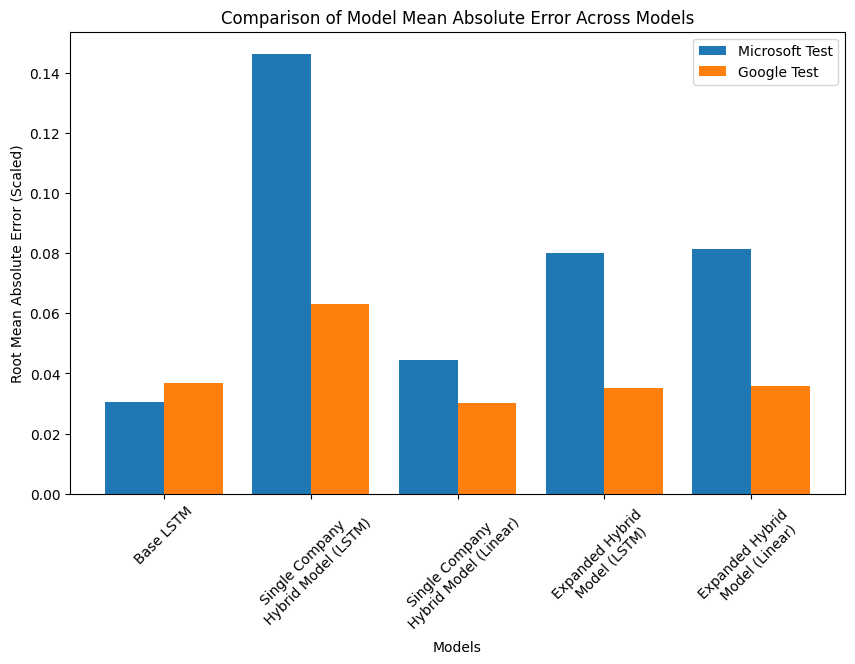

In [74]:
import seaborn as sns
x = ['Base LSTM', 'Single Company \n Hybrid Model (LSTM)', 'Single Company \n Hybrid Model (Linear)', "Expanded Hybrid \n Model (LSTM)", "Expanded Hybrid \n Model (Linear)"]
msft = [msft_lstm_mse, msft_single_mse, msft_sing_linear_mse, msft_expanded_mse, msft_exlin_mse]
goog = [goog_lstm_mse, goog_single_mse, goog_linear_mse, goog_expanded_mse, goog_exlin_mse]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')

plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Root Mean Absolute Error (Scaled)")
plt.title("Comparison of Model Mean Absolute Error Across Models")
plt.xticks(rotation = 45)
plt.legend()
plt.show()